Brandon Connors  
10/29/23  
Detecting Outliers

In [1]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing the Connection String

In [2]:

import json

# Loading the json file that contains the connection string
with open('D:\\School\\Fall 2023\\secrets.json') as d:
    data = json.load(d)

    # Extracting the connection string from the file
    connectionString = data['mongodbRead']

# Sanity check to make sure that I've pulled the right data
print(f"My connection string is {len(connectionString)} characters in length.")



My connection string is 73 characters in length.


### Connecting to the Database and Verifying the Connection

In [3]:
# I copied this section of code from the professor's sample code labeled "Basics of Loading Data" and then modified it to work with my connection string above

import pymongo
import certifi

# Connect to the database using known good certificates
client = pymongo.MongoClient(connectionString, tlsCAFile=certifi.where())

# Fetch the database named "DA320"
da320_database = client['DA320']

# Within the database we have "collections". Think of them as tables in SQL.
allCollections = da320_database.list_collection_names()

# Here is the list of collections within my database
print(f"Using MongoDB version {client.server_info()['version']}.")
print(f"This database has the collections {allCollections}")

Using MongoDB version 6.0.11.
This database has the collections ['MetacriticMovies', 'IMDB_Superhero_2']


### Loading the Data

In [26]:
# Again, here I copied the code from the professor and modified it to extract just a single year's worth of data

import pandas as pd
import re

# Here I've got the query developed in MongoDB Compass and then exported to Python code using the export function
query = {'release_date': re.compile(r"2005")}

# Execute this query and produce a cursor
cursor = da320_database["IMDB_Superhero_2"].find(query)

# Convert this information into a Pandas dataframe
imdb = pd.DataFrame(cursor)

# Checking the number of results
print(f"My resulting table has {len(imdb.id)} results")

# Make sure we've read the information correctly
imdbFinal.head()

My resulting table has 817 results


,_id,id,title,runtime,user_rating,votes,mpaa_rating,release_date,budget,opening_weekend,gross_sales,genres,cast,director,producer,company
0,652cd358f089e541968ca9be,414387,Pride & Prejudice,129.0,7.8,289263,PG,2005-07-25,28000000.0,NaN,121147947.0,"Drama, Romance","Keira Knightley, Talulah Riley, Rosamund Pike,...",Joe Wright,"Tim Bevan, Liza Chasin, Eric Fellner, Jane Fra...","Focus Features, Universal Pictures, StudioCana..."
1,652cd358f089e541968ca9cf,401792,Sin City,124.0,8.0,761770,R,2005-03-28,40000000.0,29120273.0,158753820.0,"Crime, Thriller","Jessica Alba, Devon Aoki, Alexis Bledel, Power...","Frank Miller, Quentin Tarantino, Robert Rodriguez","Elizabeth Avellan, Bill Scott, Bob Weinstein, ...","Dimension Films, Troublemaker Studios"
2,652cd358f089e541968ca9d2,399146,A History of Violence,96.0,7.4,236845,R,2005-05-16,32000000.0,515992.0,61477797.0,"Action, Crime, Drama, Thriller","Viggo Mortensen, Maria Bello, Ed Harris, Willi...",David Cronenberg,"Kent Alterman, Chris Bender, Cale Boyter, Josh...","New Line Cinema, BenderSpink, Media I! Filmpro..."
3,652cd358f089e541968ca9d5,320661,Kingdom of Heaven,144.0,7.2,284768,R,2005-05-02,130000000.0,NaN,211652051.0,"Action, Adventure, Drama, History, War","Martin Hancock, Michael Sheen, Nathalie Cox, E...",Ridley Scott,"Karim Abouobayd, Mark Albela, Bruce Devan, Lis...","Twentieth Century Fox, Scott Free Productions,..."
4,652cd358f089e541968ca9d8,358082,Robots,91.0,6.4,144984,PG,2005-03-10,75000000.0,36045301.0,260718330.0,"Animation, Adventure, Comedy, Family, Romance,...","Paula Abdul, Halle Berry, Lucille Bliss, Terry...","Chris Wedge, Carlos Saldanha","Jerry Davis, John C. Donkin, Bob Gordon, Willi...","Twentieth Century Fox Animation, Blue Sky Studios"


### Plotting the Data

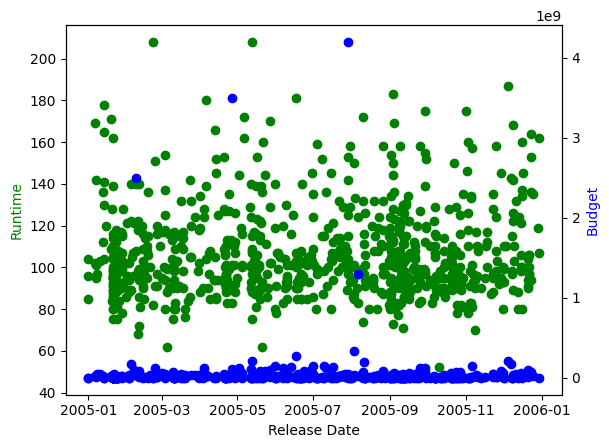

In [28]:
from matplotlib import pyplot as plt

# Here I am converting the release date to a datetime format, and even though it appears as though the runtime and budget are already numbers, I am converting them to numbers in the event there are some entries that aren't already numbers.
imdbFinal.release_date = pd.to_datetime(imdb['release_date'], errors='coerce')
imdbFinal.runtime = pd.to_numeric(imdb['runtime'], errors='coerce')
imdbFinal.budget = pd.to_numeric(imdb['budget'], errors='coerce')

# I used the following code from https://stackoverflow.com/questions/69222045/how-to-make-a-scatter-plot-with-two-y-axes-x-y1-and-y2-with-python to plot both runtime and budget on the same scatterplot against the release date.
fig, ax1 = plt.subplots()

# The twinx() function allows you to create a second y-axis that uses the same x-axis
ax2 = ax1.twinx()
ax1.scatter(imdbFinal.release_date, imdbFinal.runtime, color='g')
ax2.scatter(imdbFinal.release_date, imdbFinal.budget, color='b')

# Sets the axis labels so that it's easy to identify the data
ax1.set_xlabel('Release Date')
ax1.set_ylabel('Runtime', color='g')
ax2.set_ylabel('Budget', color='b')

plt.show()

### Identifying Budget Outliers

In [31]:
# Here I am doing a query on which budgets are over 2.5e8 to be able to identify which movies' budgets are outliers
budgetOutlierQuery = {
    'release_date': re.compile(r"2005"), 
    'budget': {
        '$gt': 2.5e8
              }
            }
# Execute this query and produce a cursor
budgetOutlierCursor = da320_database["IMDB_Superhero_2"].find(budgetOutlierQuery)

# Convert this information into a Pandas dataframe
imdbBudgetOutliers = pd.DataFrame(budgetOutlierCursor)

# Checking the number of results
print(f"My resulting table has {len(imdbBudgetOutliers.id)} results")

# Display the results
display(imdbBudgetOutliers)

My resulting table has 6 results


,_id,id,title,runtime,user_rating,votes,mpaa_rating,release_date,budget,opening_weekend,gross_sales,genres,cast,director,producer,company
0,652cd358f089e541968caa31,451094,Lady Vengeance,115,7.5,78299,R,7/29/2005,4200000000,None,NaN,"Crime, Drama, Thriller","Nam-mi Kang, Jeong-nam Choi, Hye-Sook Go, Bok-...",Park Chan-wook,"J.J. Harris, Yeong-wook Jo, Beth Kono, Chun-ye...","CJ Entertainment, CJ Capital Investment, Centu..."
1,652cd358f089e541968cab1e,367082,Fateless,140,7.0,6845,R,2/8/2005,2500000000,None,NaN,"Drama, Romance, War","Marcell Nagy, Béla Dóra, Bálint Péntek, Áron D...",Lajos Koltai,"Péter Barbalics, Robert Buckler, Andras Hamori...","Hungarian Motion Picture Ltd., Magic Media Inc..."
2,652cd358f089e541968caafe,376127,Anniyan,181,8.3,17878,Not Rated,6/17/2005,280000000,None,570000000.0,"Action, Drama, Thriller","Vikram, Sada, Prakash Raj, Vivek, Nedumudi Ven...",S. Shankar,"D. Ramesh Babu, Viswanathan Ravichandran","Oscar Films International, Oscar Films"
3,652cd359f089e541968cabe2,346457,Mangal Pandey,150,6.5,9993,Not Rated,8/3/2005,340000000,None,NaN,"Biography, Drama, History, War","Aamir Khan, Rani Mukerji, Toby Stephens, Coral...",Ketan Mehta,"Bobby Bedi, Puja Bedi, Varsha Bedi, Alice Daws...",NH Studioz
4,652cd359f089e541968cac61,441641,Joni's Promise,83,7.6,1394,TV-PG,4/27/2005,3500000000,None,NaN,"Adventure, Comedy, Drama, Romance","Nicholas Saputra, Mariana Renata, Rachel Marya...",Joko Anwar,"Nia Di Nata, Constantin Papadimitriou, Sugeng ...",Kalyana Shira Film
5,652cd359f089e541968cab94,425661,The Great Yokai War,124,6.3,2476,PG-13,8/6/2005,1300000000,None,NaN,"Adventure, Family, Fantasy","Ryûnosuke Kamiki, Hiroyuki Miyasako, Chiaki Ku...",Takashi Miike,"Fumio Inoue, Tsuguhiko Kadokawa","Kadokawa Eiga K.K., Nippon Television Network"


Looking at the budget outliers, we can see a set of six films, each produced outside of the United States. Specifically: Korea, Hungaria, two India, Indonesia, and Japan.  
Because of how much higher these films' budgets are, I believe it can be safely assumed that these amounts were not recorded in USD, but rather the local currency.  
As a result, I would probably leave these items out of my final graph.

### Identifying Runtime Outliers

In [22]:
# Based on the graph above, I feel like the only potential outliers are those that are either under 65 minutes or over 200 minutes. As a result I am doing a query to identify which items match those conditions in order to figure out if they're actually "movies" or not.
runtimeOutlierQuery = {
    'release_date': re.compile(r"2005"), 
    '$or': [
        {
            'runtime': {
                '$lt': 65
            }
        }, {
            'runtime': {
                '$gt': 200
            }
        }
    ]
}

# Execute this query and produce a cursor
runtimeOutlierCursor = da320_database["IMDB_Superhero_2"].find(runtimeOutlierQuery)

# Convert this information into a Pandas dataframe
imdbRuntimeOutliers = pd.DataFrame(runtimeOutlierCursor)

# Checking the number of results
print(f"My resulting table has {len(imdbRuntimeOutliers.id)} results")

# Display the results
display(imdbRuntimeOutliers)

My resulting table has 7 results


,_id,id,title,runtime,user_rating,votes,mpaa_rating,release_date,budget,opening_weekend,gross_sales,genres,cast,director,producer,company
0,652cd358f089e541968caaf1,478988,The Call of Cthulhu,47,7.2,8365,Not Rated,10/7/2005,50000.0,None,None,"Horror, Mystery","Matt Foyer, John Bolen, Ralph Lucas, Chad Fife...",Andrew Leman,"Sean Branney, Chris Lackey, Andrew Leman",The H.P. Lovecraft Historical Society
1,652cd358f089e541968cab23,491399,Haze,49,6.4,2722,Not Rated,4/28/2005,NaN,None,None,"Horror, Mystery","Shin'ya Tsukamoto, Takahiro Murase, Takahiro K...",Shin'ya Tsukamoto,"Shin'ichi Kawahara, Shin'ya Tsukamoto",", , , ,"
2,652cd358f089e541968cab3d,349878,Netaji Subhas Chandra Bose: The Forgotten Hero,208,7.5,1241,None,5/13/2005,210000000.0,None,None,"Biography, Drama, History, War","Vinay Anand, Ila Arun, Pankaj Berry, Nicolas C...",Shyam Benegal,"Raj Pius, Satish Sharma, Barbara von Wrangell","Sahara India Media Communication Ltd., Shyam B..."
3,652cd359f089e541968cabbf,374298,Turetskiy gambit,208,6.9,4532,None,2/22/2005,4000000.0,None,None,"Action, Drama, Mystery, Thriller, War","Egor Beroev, Olga Krasko, Marat Basharov, Vlad...",Dzhanik Fayziev,"Konstantin Ernst, Anatoliy Maksimov, Alexander...","Channel One Russia, Studio Trite"
4,652cd359f089e541968cac08,493393,Ashes and Snow,62,8.1,4175,NaN,3/5/2005,NaN,None,None,"Documentary, Drama","Patrick Disanto, Laurence Fishburne, Jeanne Mo...",Gregory Colbert,"Gregory Colbert, John Oetjen, Alessandra Pasquino",Flying Elephants Productions
5,652cd359f089e541968cac9e,455507,The God Who Wasn't There,62,6.9,4989,None,5/21/2005,NaN,None,None,"Documentary, Biography, History","Sam Harris, Robert M. Price, Richard Carrier, ...",Brian Flemming,"Brian Flemming, Amanda Jackson",Beyond Belief Media
6,652cd359f089e541968cacf6,892425,Before Flying Back to Earth,52,8.7,1167,NaN,10/10/2005,NaN,None,None,Documentary,", , , ,",Arunas Matelis,"Gerd Haag, Arunas Matelis, Mindaugas Mozuraiti...","Nomimun, TAG/TRAUM Filmproduktion, ZDF Product..."


Looking at the runtime outliers, it seems like there aren't any particularly noteworthy items that I would want to exclude in the plot.  
The two longer titles appear to be films about war, which tend to be longer, more epic films, and so these items do not seem worthy of exclusion.  
On the other hand, the four shorter titles seem to be featurettes or documentaries, either of which seem fine to include in the results.


### Final Query and Plot

My resulting table has 811 results


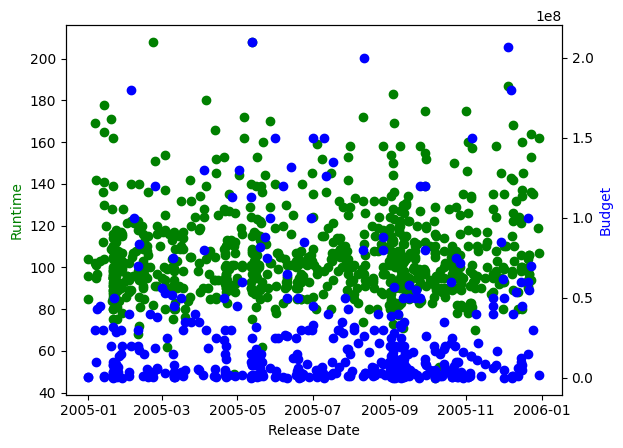

In [32]:
# Here I am doing a query on which budgets are over 1e9 to be able to identify which movies' budgets are outliers
finalQuery = {
    'release_date': re.compile(r"2005"), 
    '$or': [
        {
            'budget': {
                '$lt': 2.5e8
            }
        }, {
            'budget': None
        }
    ]
}
# Execute this query and produce a cursor
finalCursor = da320_database["IMDB_Superhero_2"].find(finalQuery)

# Convert this information into a Pandas dataframe
imdbFinal = pd.DataFrame(finalCursor)

# Checking the number of results
print(f"My resulting table has {len(imdbFinal.id)} results")

# Here I am converting the release date to a datetime format, and even though it appears as though the runtime and budget are already numbers, I am converting them to numbers in the event there are some entries that aren't already numbers.
imdbFinal.release_date = pd.to_datetime(imdbFinal['release_date'], errors='coerce')
imdbFinal.runtime = pd.to_numeric(imdbFinal['runtime'], errors='coerce')
imdbFinal.budget = pd.to_numeric(imdbFinal['budget'], errors='coerce')

# I used the following code from https://stackoverflow.com/questions/69222045/how-to-make-a-scatter-plot-with-two-y-axes-x-y1-and-y2-with-python to plot both runtime and budget on the same scatterplot against the release date.
fig, ax1Final = plt.subplots()

# The twinx() function allows you to create a second y-axis that uses the same x-axis
ax2Final = ax1Final.twinx()
ax1Final.scatter(imdbFinal.release_date, imdbFinal.runtime, color='g')
ax2Final.scatter(imdbFinal.release_date, imdbFinal.budget, color='b')

# Sets the axis labels so that it's easy to identify the data
ax1Final.set_xlabel('Release Date')
ax1Final.set_ylabel('Runtime', color='g')
ax2Final.set_ylabel('Budget', color='b')

plt.show()

This plot is more useful, showing the budget results more spread out, allowing you to get a better view of the data.